In [1]:
# # Comment the following lines if you're not in colab:
# from google.colab import drive
# drive.mount('/content/drive')
# # # If you're in colab, cd to your own working directory here:
# %cd ..//..//content//drive//MyDrive//Colab-Notebooks//HY-673-Tutorials//Tutorial-10

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab-Notebooks/HY-673-Tutorials/Tutorial-9


### Imports

In [1]:
import torch as tc
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim import Adam
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
seed = 42
tc.manual_seed(seed)
np.random.seed(seed)
device = 'cuda' if tc.cuda.is_available() else 'cpu'
print(f"Using {device}")

epochs = 50
batch_size = 128
lr = 2e-4
betas = (0.5, 0.999)

Using cuda


### Batch Normalization (1D)

Applies Batch Normalization over a 2D or 3D input as described in https://arxiv.org/pdf/1502.03167.pdf
\begin{equation}
y = \frac{x - \mathbb{E}[x]}{\sqrt{\text{Var}[x] + \epsilon}} * \gamma + \beta,
\end{equation}
where $x$ is the input, $y$ is the output, $\gamma$ and $\beta$ are trainable parameter vectors of size $C$ = number of features/channels of the input, and $\epsilon$ is a small value for numerical stability.

### Generator (G)

Same architecture type with fewer layers and batch normalization:

In [3]:
class Generator(nn.Module):
    def __init__(self, input_shape=(1, 28, 28), noise_shape=(100,)):
        super().__init__()
        self.noise_shape = noise_shape
        self.noise_dim = np.prod(noise_shape)
        self.data_shape = input_shape
        self.data_dim = np.prod(input_shape)
        layers_config = [
            (self.noise_dim, 128), # (in_channels, out_channels)
            (128, 256),
            (256, 512)
        ]
        layers = []
        for in_features, out_features in layers_config:
            layers.append(nn.Linear(in_features=in_features, out_features=out_features))
            layers.append(nn.PReLU())
            layers.append(nn.BatchNorm1d(num_features=out_features))
        layers.append(nn.Linear(in_features=layers_config[-1][1], out_features=self.data_dim))
        layers.append(nn.Tanh())
        self.generator = nn.Sequential(*layers)

    def forward(self, noise):
        noise = noise.view(-1, self.noise_dim)
        return self.generator(noise).view(-1, *self.data_shape)

### Discriminator (D)

Same architecture type with fewer layers and batch normalization:

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_shape=(1, 28, 28)):
        super().__init__()
        self.data_shape = input_shape
        self.data_dim = np.prod(input_shape)
        layers = []
        conv_layers = [
            (1, 64),  # (in_channels, out_channels)
            (64, 128)
        ]
        for in_channels, out_channels in conv_layers:
            layers.append(nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=1, padding=1
            ))
            layers.append(nn.PReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        layers.append(nn.Flatten())
        feature_map_size = (input_shape[1] // 4) * (input_shape[2] // 4) * conv_layers[-1][1]
        layers.append(nn.Linear(in_features=feature_map_size, out_features=128))
        layers.append(nn.Linear(in_features=128, out_features=1))
        layers.append(nn.Sigmoid())
        self.discriminator = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, *self.data_shape)
        return self.discriminator(x)

### Dataset

In [5]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
train_set = MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

### Models

In [6]:
data_shape = (1, 28, 28)
noise_dim = 100

In [7]:
def print_dims(architecture, in_shape):
    print(f"In shape = {in_shape}")
    dummy_input = tc.randn(in_shape).to(device)
    current_output = dummy_input
    for layer in architecture:
        current_output = layer(current_output)
        print(f"Out shape after {type(layer).__name__} = {current_output.shape}")

In [8]:
gen = Generator(input_shape=data_shape, noise_shape=(noise_dim,)).to(device)
opt_gen = Adam(params=gen.parameters(), lr=lr, betas=betas)

_ = summary(model=gen, input_data=tc.zeros(size=(batch_size, noise_dim)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 784]                 --
|    └─Linear: 2-1                       [-1, 128]                 12,928
|    └─PReLU: 2-2                        [-1, 128]                 1
|    └─BatchNorm1d: 2-3                  [-1, 128]                 256
|    └─Linear: 2-4                       [-1, 256]                 33,024
|    └─PReLU: 2-5                        [-1, 256]                 1
|    └─BatchNorm1d: 2-6                  [-1, 256]                 512
|    └─Linear: 2-7                       [-1, 512]                 131,584
|    └─PReLU: 2-8                        [-1, 512]                 1
|    └─BatchNorm1d: 2-9                  [-1, 512]                 1,024
|    └─Linear: 2-10                      [-1, 784]                 402,192
|    └─Tanh: 2-11                        [-1, 784]                 --
Total params: 581,523
Trainable params: 581,523
Non-trainable par

In [9]:
disc = Discriminator(input_shape=data_shape).to(device)
opt_disc = Adam(params=disc.parameters(), lr=lr, betas=betas)

_ = summary(model=disc, input_data=tc.zeros(size=(batch_size, np.prod(data_shape))))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 64, 28, 28]          640
|    └─PReLU: 2-2                        [-1, 64, 28, 28]          1
|    └─MaxPool2d: 2-3                    [-1, 64, 14, 14]          --
|    └─Conv2d: 2-4                       [-1, 128, 14, 14]         73,856
|    └─PReLU: 2-5                        [-1, 128, 14, 14]         1
|    └─MaxPool2d: 2-6                    [-1, 128, 7, 7]           --
|    └─Flatten: 2-7                      [-1, 6272]                --
|    └─Linear: 2-8                       [-1, 128]                 802,944
|    └─Linear: 2-9                       [-1, 1]                   129
|    └─Sigmoid: 2-10                     [-1, 1]                   --
Total params: 877,571
Trainable params: 877,571
Non-trainable params: 0
Total mult-adds (M): 16.58
Input size (MB): 0.38
Forward/backward pass siz

### Generation/Sampling

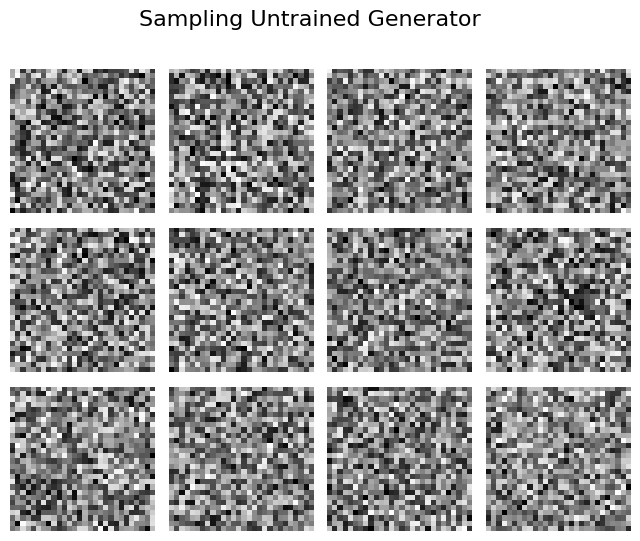

In [11]:
def generate(n_samples, title):
    z = tc.randn(n_samples, noise_dim)
    z = z.to(device)
    x_hat = gen(z)
    x_hat = x_hat.detach().cpu().numpy().reshape(-1, 28, 28)

    # The rest is just plotting:
    n_rows = (n_samples + 3) // 4
    fig, axs = plt.subplots(
        nrows=n_rows,
        ncols=4,
        figsize=(8, 2*n_rows),
        subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False}
    )
    for i, axis in enumerate(axs.flat[:n_samples]):
        axis.imshow(x_hat[i], cmap='binary')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.suptitle(title, fontsize=16)
    plt.show()
    plt.close()

no_samples = 12
generate(no_samples, title="Sampling Untrained Generator")

### Training

100%|██████████| 469/469 [00:32<00:00, 14.37it/s]


Epoch [1/50] | Loss D: 0.1970 | Loss G: 7.7882


100%|██████████| 469/469 [00:22<00:00, 20.46it/s]


Epoch [2/50] | Loss D: 0.2262 | Loss G: 5.4097


100%|██████████| 469/469 [00:23<00:00, 19.68it/s]


Epoch [3/50] | Loss D: 0.2164 | Loss G: 4.3214


100%|██████████| 469/469 [00:24<00:00, 19.05it/s]


Epoch [4/50] | Loss D: 0.2380 | Loss G: 3.7067


100%|██████████| 469/469 [00:23<00:00, 19.73it/s]


Epoch [5/50] | Loss D: 0.2291 | Loss G: 3.0098


100%|██████████| 469/469 [00:23<00:00, 19.75it/s]


Epoch [6/50] | Loss D: 0.1981 | Loss G: 2.9539


100%|██████████| 469/469 [00:23<00:00, 20.17it/s]


Epoch [7/50] | Loss D: 0.2403 | Loss G: 2.8611


100%|██████████| 469/469 [00:23<00:00, 19.78it/s]


Epoch [8/50] | Loss D: 0.2509 | Loss G: 2.5605


100%|██████████| 469/469 [00:23<00:00, 20.02it/s]


Epoch [9/50] | Loss D: 0.2409 | Loss G: 2.5601


100%|██████████| 469/469 [00:22<00:00, 20.46it/s]


Epoch [10/50] | Loss D: 0.2321 | Loss G: 2.6058


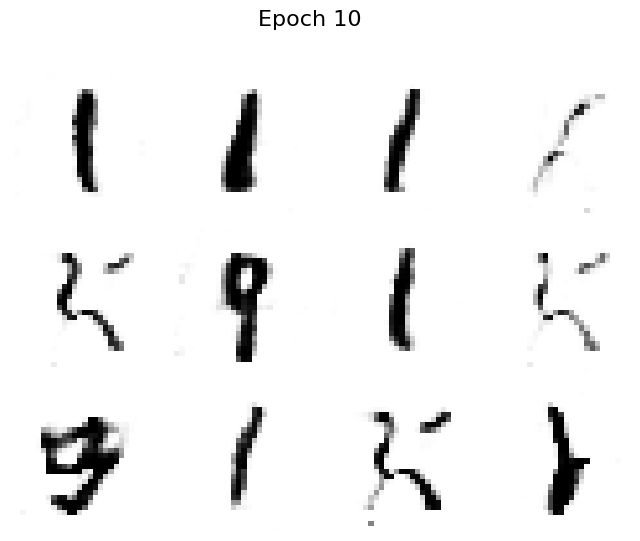

100%|██████████| 469/469 [00:23<00:00, 20.02it/s]


Epoch [11/50] | Loss D: 0.2311 | Loss G: 2.5678


100%|██████████| 469/469 [00:23<00:00, 20.12it/s]


Epoch [12/50] | Loss D: 0.2416 | Loss G: 2.3931


100%|██████████| 469/469 [00:23<00:00, 19.76it/s]


Epoch [13/50] | Loss D: 0.2350 | Loss G: 2.4498


100%|██████████| 469/469 [00:22<00:00, 20.58it/s]


Epoch [14/50] | Loss D: 0.2377 | Loss G: 2.4769


100%|██████████| 469/469 [00:23<00:00, 20.03it/s]


Epoch [15/50] | Loss D: 0.2396 | Loss G: 2.4178


100%|██████████| 469/469 [00:23<00:00, 19.88it/s]


Epoch [16/50] | Loss D: 0.2325 | Loss G: 2.4663


100%|██████████| 469/469 [00:23<00:00, 19.78it/s]


Epoch [17/50] | Loss D: 0.2376 | Loss G: 2.3878


100%|██████████| 469/469 [00:22<00:00, 20.40it/s]


Epoch [18/50] | Loss D: 0.2333 | Loss G: 2.4258


100%|██████████| 469/469 [00:23<00:00, 20.03it/s]


Epoch [19/50] | Loss D: 0.2404 | Loss G: 2.4495


100%|██████████| 469/469 [00:23<00:00, 19.91it/s]


Epoch [20/50] | Loss D: 0.2323 | Loss G: 2.4859


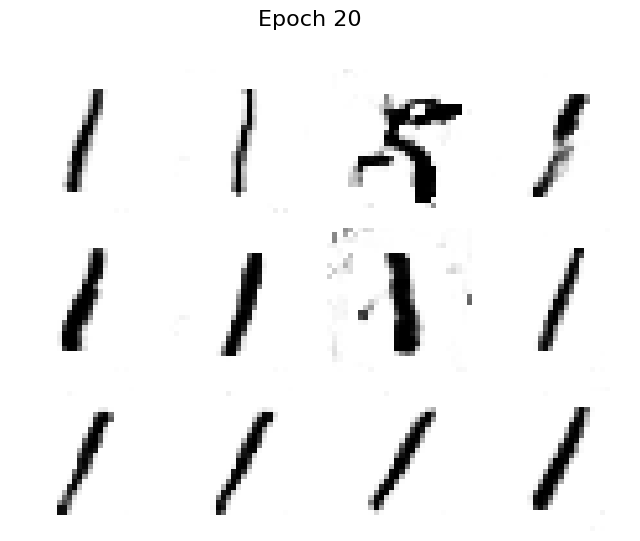

100%|██████████| 469/469 [00:23<00:00, 19.82it/s]


Epoch [21/50] | Loss D: 0.2266 | Loss G: 2.4621


100%|██████████| 469/469 [00:22<00:00, 20.64it/s]


Epoch [22/50] | Loss D: 0.2266 | Loss G: 2.4464


100%|██████████| 469/469 [00:23<00:00, 20.24it/s]


Epoch [23/50] | Loss D: 0.2128 | Loss G: 2.4883


100%|██████████| 469/469 [00:23<00:00, 19.89it/s]


Epoch [24/50] | Loss D: 0.2107 | Loss G: 2.5174


100%|██████████| 469/469 [00:23<00:00, 20.06it/s]


Epoch [25/50] | Loss D: 0.2048 | Loss G: 2.5670


100%|██████████| 469/469 [00:22<00:00, 20.72it/s]


Epoch [26/50] | Loss D: 0.2093 | Loss G: 2.5592


100%|██████████| 469/469 [00:23<00:00, 20.17it/s]


Epoch [27/50] | Loss D: 0.2063 | Loss G: 2.5357


100%|██████████| 469/469 [00:23<00:00, 19.93it/s]


Epoch [28/50] | Loss D: 0.2074 | Loss G: 2.5955


100%|██████████| 469/469 [00:23<00:00, 19.89it/s]


Epoch [29/50] | Loss D: 0.1987 | Loss G: 2.5691


100%|██████████| 469/469 [00:23<00:00, 20.37it/s]


Epoch [30/50] | Loss D: 0.1943 | Loss G: 2.6492


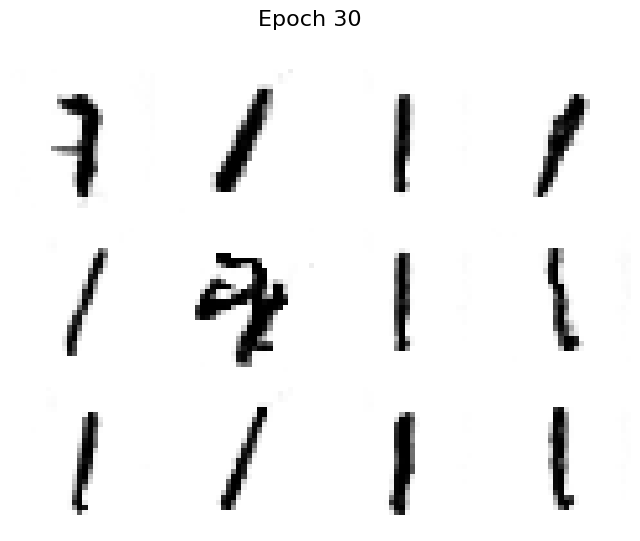

100%|██████████| 469/469 [00:23<00:00, 19.78it/s]


Epoch [31/50] | Loss D: 0.1871 | Loss G: 2.6457


100%|██████████| 469/469 [00:24<00:00, 19.37it/s]


Epoch [32/50] | Loss D: 0.1842 | Loss G: 2.6986


100%|██████████| 469/469 [00:24<00:00, 19.41it/s]


Epoch [33/50] | Loss D: 0.1779 | Loss G: 2.6901


100%|██████████| 469/469 [00:24<00:00, 19.38it/s]


Epoch [34/50] | Loss D: 0.1816 | Loss G: 2.7099


100%|██████████| 469/469 [00:23<00:00, 19.84it/s]


Epoch [35/50] | Loss D: 0.1791 | Loss G: 2.6887


100%|██████████| 469/469 [00:24<00:00, 19.27it/s]


Epoch [36/50] | Loss D: 0.1822 | Loss G: 2.6609


100%|██████████| 469/469 [00:26<00:00, 17.37it/s]


Epoch [37/50] | Loss D: 0.1807 | Loss G: 2.6462


100%|██████████| 469/469 [00:24<00:00, 19.27it/s]


Epoch [38/50] | Loss D: 0.1846 | Loss G: 2.6888


100%|██████████| 469/469 [00:24<00:00, 19.38it/s]


Epoch [39/50] | Loss D: 0.1826 | Loss G: 2.6920


100%|██████████| 469/469 [00:23<00:00, 20.08it/s]


Epoch [40/50] | Loss D: 0.1812 | Loss G: 2.6587


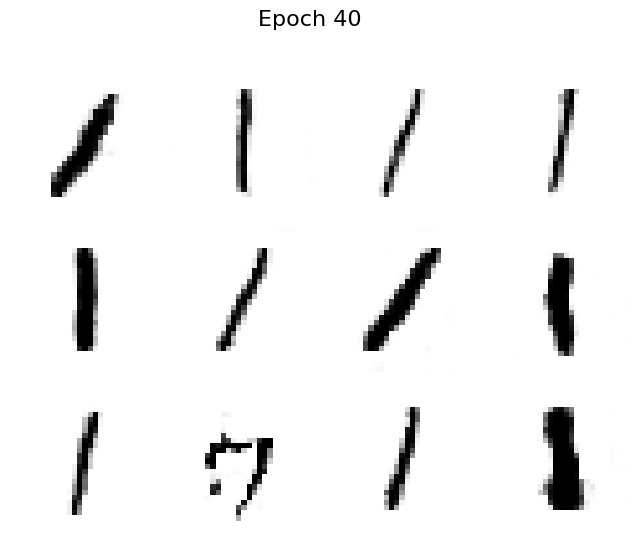

100%|██████████| 469/469 [00:24<00:00, 19.05it/s]


Epoch [41/50] | Loss D: 0.1773 | Loss G: 2.6871


100%|██████████| 469/469 [00:24<00:00, 19.36it/s]


Epoch [42/50] | Loss D: 0.1766 | Loss G: 2.6746


100%|██████████| 469/469 [00:23<00:00, 19.61it/s]


Epoch [43/50] | Loss D: 0.1740 | Loss G: 2.7183


100%|██████████| 469/469 [00:23<00:00, 19.55it/s]


Epoch [44/50] | Loss D: 0.1740 | Loss G: 2.7661


100%|██████████| 469/469 [00:22<00:00, 20.49it/s]


Epoch [45/50] | Loss D: 0.1686 | Loss G: 2.7314


100%|██████████| 469/469 [00:23<00:00, 19.63it/s]


Epoch [46/50] | Loss D: 0.1627 | Loss G: 2.7978


100%|██████████| 469/469 [00:23<00:00, 19.74it/s]


Epoch [47/50] | Loss D: 0.1571 | Loss G: 2.7657


100%|██████████| 469/469 [00:24<00:00, 19.43it/s]


Epoch [48/50] | Loss D: 0.1547 | Loss G: 2.8065


100%|██████████| 469/469 [00:23<00:00, 20.08it/s]


Epoch [49/50] | Loss D: 0.1562 | Loss G: 2.7830


100%|██████████| 469/469 [00:23<00:00, 19.68it/s]


Epoch [50/50] | Loss D: 0.1547 | Loss G: 2.7830


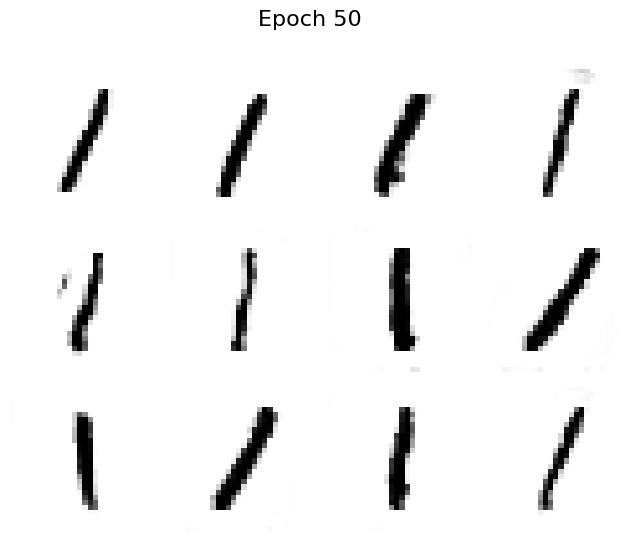

In [12]:
def train_loop():

    loss_fn = nn.BCELoss()

    disc_losses = np.zeros(epochs)
    gen_losses = np.zeros(epochs)
    sample_every = 10
    gen.train()
    disc.train()

    for epoch in range(epochs):

        gen_loss = 0
        disc_loss = 0

        for i, (x, _) in enumerate(tqdm(train_loader)):

            # ------------------------ Train Discriminator: ------------------------
            opt_disc.zero_grad()
            x = x.to(device)
            z = tc.randn(x.shape[0], noise_dim).to(device)
            x_hat = gen(z)

            target_real = tc.ones((x.shape[0], 1)).to(device)
            target_fake = tc.zeros((x.shape[0], 1)).to(device)
            pred_real = disc(x)
            pred_fake = disc(x_hat)

            loss_real = loss_fn(pred_real, target_real)
            loss_fake = loss_fn(pred_fake, target_fake)
            loss_disc = (loss_real + loss_fake) / 2
            disc_loss += loss_disc.item()

            loss_disc.backward()
            opt_disc.step()

            # ------------------------ Train Generator: ------------------------
            z = tc.randn(x.shape[0], noise_dim).to(device)
            x_hat = gen(z)

            target_real = tc.ones((x.shape[0], 1)).to(device)
            pred_fake = disc(x_hat)

            loss_gen = loss_fn(pred_fake, target_real)
            gen_loss += loss_gen.item()

            gen.zero_grad()
            loss_gen.backward()
            opt_gen.step()

        # Print:
        disc_losses[epoch] = disc_loss / len(train_loader)
        gen_losses[epoch] = gen_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] | Loss D: {disc_losses[epoch]:.4f} | Loss G: {gen_losses[epoch]:.4f}")
        # Sample:
        if (epoch + 1) % sample_every == 0:
            gen.eval()
            generate(no_samples, f"Epoch {epoch + 1}")
            gen.train()

    return disc_losses, gen_losses

d_loss, g_loss = train_loop()

# ↑ Mode Collapse
Mode collapse in GANs is a significant challenge where G learns to produce a limited variety of outputs, even though the training data shows much greater diversity. Some common causes are:

- **Rapid Convergence of Discriminator:** If the discriminator converges too quickly, it can overpower the generator, leading to vanishing gradients for the generator. This scenario makes it difficult for the generator to explore and learn from the full distribution of the training data, potentially causing mode collapse.
- **High Learning Rates:** An excessively high learning rate can cause the training to oscillate around the optimal model parameters without properly converging. This can also lead the generator to find and stick to specific outputs that are easier to learn, rather than exploring a diverse set.
- **Loss Function Issues:** The choice and design of the loss function can significantly affect the dynamics of training in GANs. Some loss functions may inherently encourage the generator to focus on minimizing errors in ways that do not encourage diversity (e.g., if the loss strongly penalizes deviations from certain successful outputs).
- **Limited Model Capacity/Bad Architecture:** If the generator lacks sufficient complexity or capacity or is generally not designed well, it might not be capable of learning to produce a diverse range of outputs. Model capacity can limit the types of distributions the generator can learn, forcing it into repeating certain patterns.
- **Unstable Training Dynamics:** GANs are notoriously difficult to train due to the delicate balance needed between the generator and discriminator. Instabilities in training, often exacerbated by issues like improper initialization or unsuitable optimizer settings, can lead to mode collapse.
- **Poor Data Variability or Quality:** Inadequate or unrepresentative training data can limit the generator’s ability to produce diverse outputs. Similarly, if the data itself lacks variability, the generator may not learn to produce anything beyond a narrow slice of potential outputs.
- **Improper Data/Batch Processing:** The way batches are constructed during training can also lead to mode collapse, especially if batches do not sufficiently represent the variability in the dataset. This can occur if batching methods inadvertently bias the data seen by the generator during training.

# Plot Losses

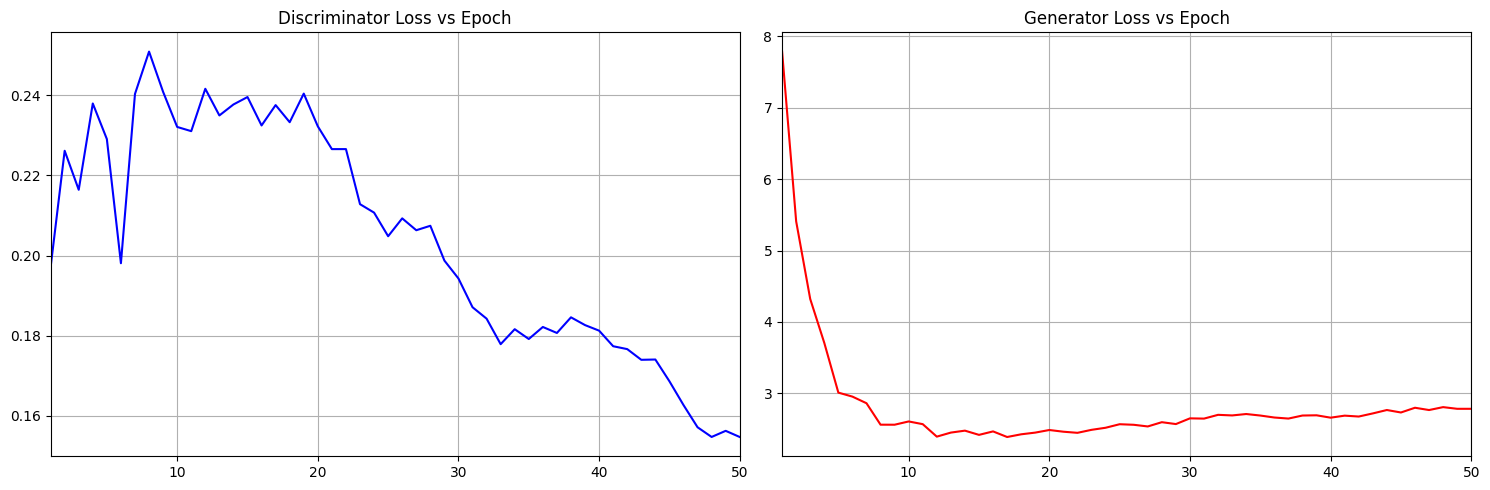

In [13]:
epoch_ax = np.arange(start=1, stop=epochs+1, step=1)
_, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(epoch_ax, d_loss, color='blue')
ax[0].set_xlim(1, epochs)
ax[0].set_title("Discriminator Loss vs Epoch")
ax[0].grid()

ax[1].plot(epoch_ax, g_loss, color='red')
ax[1].set_xlim(1, epochs)
ax[1].set_title("Generator Loss vs Epoch")
ax[1].grid()

plt.tight_layout()
plt.show()
plt.close()

We cannot really see if this model suffers from mode collapse just by looking at our loss function plots. That is yet another reason why it is necessary to always investigate the actual generated data.